In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report

In [20]:
df=pd.read_csv('Fraud.csv')
df.shape

(6362620, 11)

In [22]:
df.head(200)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
195,1,CASH_OUT,210370.09,C2121995675,0.0,0.00,C1170794006,1442298.03,22190.99,0,0
196,1,CASH_OUT,36437.06,C2120063568,0.0,0.00,C1740000325,154606.00,1363368.51,0,0
197,1,CASH_OUT,82691.56,C1620409359,0.0,0.00,C248609774,657983.89,6453430.91,0,0
198,1,CASH_OUT,338767.10,C691691381,0.0,0.00,C453211571,544481.28,3461666.05,0,0


In [23]:
#Check if null there
df.isnull().values.any()

False

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [25]:
real_transactions = len(df[df.isFraud == 0])
fraud = len(df[df.isFraud == 1])
real_transactions_percent = (real_transactions / (fraud + real_transactions)) * 100
fraud_percent = (fraud / (fraud + real_transactions)) * 100

print("Number of Legit transactions: ", real_transactions_percent)
print("Number of Fraud transactions: ", fraud)
print("Percentage of Legit transactions: {:.4f} %".format(real_transactions_percent))
print("Percentage of Fraud transactions: {:.4f} %".format(fraud_percent))

Number of Legit transactions:  99.87091795518198
Number of Fraud transactions:  8213
Percentage of Legit transactions: 99.8709 %
Percentage of Fraud transactions: 0.1291 %


# Diagram

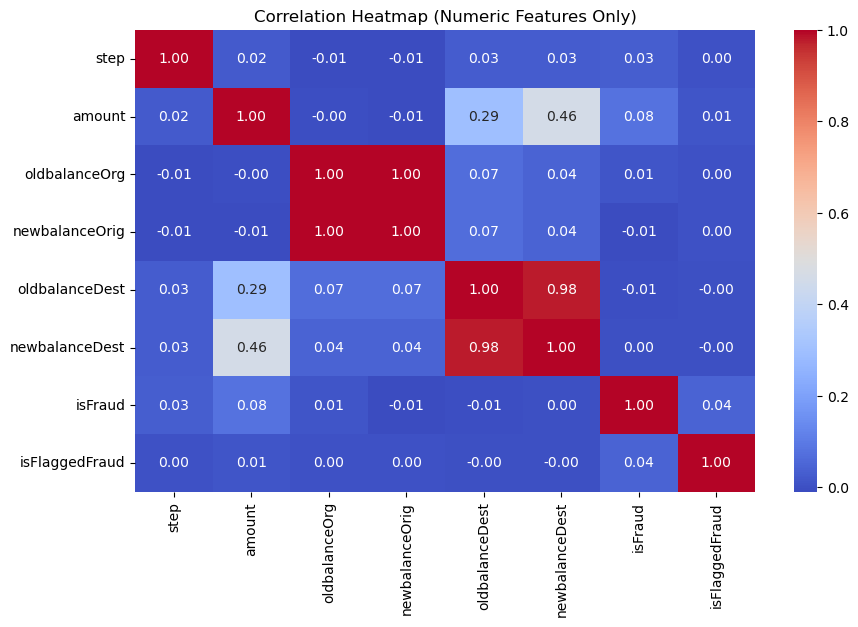

In [31]:
corr = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

This means our dataset is highly imbalanced. As we can see fraudlent transaction tracked is very few. This can be false positves or false negatives.

In [33]:
new_df=df.copy()
new_df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [35]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [37]:
objList = new_df.select_dtypes(include = "object").columns
print (objList)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


In [39]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    new_df[feat] = le.fit_transform(new_df[feat].astype(str))

print (new_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   nameOrig        int32  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int32  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int32(3), int64(3)
memory usage: 461.2 MB
None


# Checking Multicollinearity (VIF)/ Feature Engineering

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

calc_vif(new_df)

,variables,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


In [43]:
new_df['Actual_amount_orig'] = new_df['oldbalanceOrg'] - new_df['newbalanceOrig']
new_df['Actual_amount_dest'] = new_df['oldbalanceDest'] - new_df['newbalanceDest']
new_df['TransactionPath'] = new_df['nameOrig'] + new_df['nameDest']

new_df = new_df.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'], axis=1)


In [45]:
calc_vif(new_df)

,variables,VIF
0,type,2.687803
1,amount,3.818902
2,isFraud,1.184479
3,isFlaggedFraud,1.002546
4,Actual_amount_orig,1.307910
5,Actual_amount_dest,3.754335
6,TransactionPath,2.677167


<Axes: >

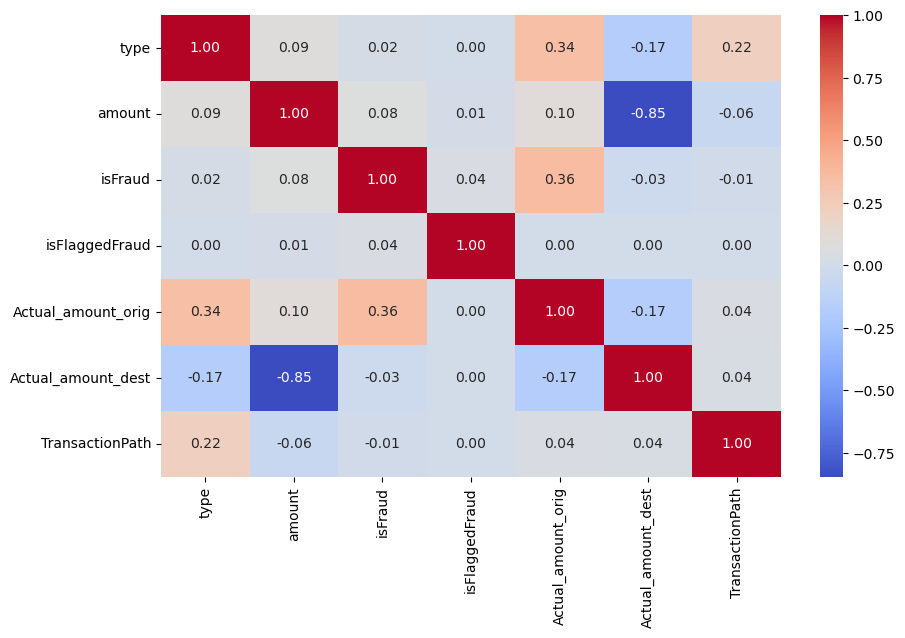

In [46]:
corr=new_df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")

# Scaling Amount

In [49]:
scaler = StandardScaler()
new_df["NormalizedAmount"] = scaler.fit_transform(new_df["amount"].values.reshape(-1, 1))
new_df.drop(["amount"], inplace= True, axis= 1)

# Train-Test Split

In [51]:
X = new_df.drop("isFraud", axis=1)
Y = new_df["isFraud"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [53]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (4453834, 6)
Shape of X_test:  (1908786, 6)


# Model Training

In [122]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.3, random_state= 42)

# Logistic Regression

In [115]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.3, random_state= 42)
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
log_reg.fit(X_train_res, Y_train_res)
Y_pred_lr = log_reg.predict(X_test)
lr_score = log_reg.score(X_test, Y_test) * 100

# Confusion Matrix of LR

Logistic Regression Report:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1906351
           1       0.03      0.86      0.05      2435

    accuracy                           0.96   1908786
   macro avg       0.51      0.91      0.52   1908786
weighted avg       1.00      0.96      0.98   1908786



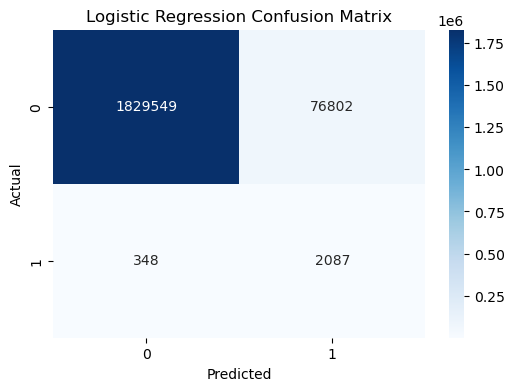

In [116]:
print("Logistic Regression Report:\n")
print(classification_report(Y_test, Y_pred_lr))
cm_lr = confusion_matrix(Y_test, Y_pred_lr)

plt.figure(figsize=(6,4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Random Forest 

In [111]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.3, random_state= 42)
random_forest = RandomForestClassifier(n_estimators= 50, random_state=42)
random_forest.fit(X_train, Y_train)

Y_pred_rf_nosmote = random_forest.predict(X_test)
random_forest_score_nosmote = random_forest.score(X_test, Y_test) * 100


Random Forest Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.97      0.70      0.81      2435

    accuracy                           1.00   1908786
   macro avg       0.98      0.85      0.91   1908786
weighted avg       1.00      1.00      1.00   1908786



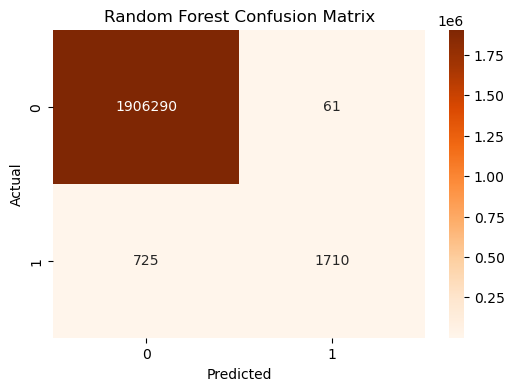

In [133]:
print("\nRandom Forest Report:\n")
print(classification_report(Y_test, Y_pred_rf_nosmote)) 
cm_rf_no = confusion_matrix(Y_test, Y_pred_rf_nosmote)

plt.figure(figsize=(6,4))
sns.heatmap(cm_rf_no, annot=True, fmt="d", cmap="Oranges")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Evaluation

In [129]:
print("Logistic Regression Score: ", lr_score)
print("Random Forest Score: ", random_forest_score_nosmote)

Logistic Regression Score:  95.95816398485739
Random Forest Score:  99.95882199471286


# Results

In [131]:
results = {
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy (%)": [95.96, 99.96],
    "Fraud Precision": [0.03, 0.97],
    "Fraud Recall": [0.86, 0.70],
    "Fraud F1-Score": [0.05, 0.81]
}

df_results = pd.DataFrame(results)

print("Model Performance Comparison:\n")
display(df_results)

Model Performance Comparison:



,Model,Accuracy (%),Fraud Precision,Fraud Recall,Fraud F1-Score
0,Logistic Regression,95.96,0.03,0.86,0.05
1,Random Forest,99.96,0.97,0.70,0.81


# Conclusion

# Question and Answers